## 0. Modules and Custom Functions

In [1]:
from collections import defaultdict

from numpy import nan
from pandas import read_csv, Categorical, cut
from matplotlib.pyplot import style, rcParams, subplots

In [2]:
style.use("ggplot")
ggcolors = rcParams['axes.prop_cycle'].by_key()['color']
rcParams["figure.figsize"] = (18, 8)

In [23]:
def get_features(df):
    
    numerical = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical = df.select_dtypes(include=["object", "category"]).columns.tolist()
    dates = df.select_dtypes(include=["datetime", "datetime64[ns]"]).columns.tolist()
    other = df.columns.difference(numerical + categorical + dates).tolist()
    
    return numerical, categorical, dates, other

In [4]:
def get_title(df):
    lastname_removed = df["name"].str.split(",").apply(lambda x: x[1])
    title = lastname_removed.str.split(".").apply(lambda x: x[0])
    clean_title = title.str.lower().str.strip()
    cat = clean_title.apply(lambda t: "other" if t not in ["mr", "mrs", "ms", "miss"] else t)
    return cat

In [5]:
def get_women_marital_status(gender, title):
    if (gender == "female") and (title in ["mrs", "ms"]):
        marital_status = True
    elif gender == "male":
        marital_status = None
    else:
        marital_status = False
    return marital_status

In [6]:
def was_adult(age):
    if age is None:
        output = None
    else:
        output = 18 < age
    return output
    

In [63]:
def plot_perc_from_total(kind, df, column, title, color, sort_index, rot=None, ax=None):
    sort_index = sort_index or False
    rot = rot or 0
    
    counts = df[column].value_counts(normalize=True, dropna=False)
    if sort_index:
        counts = counts.sort_index(ascending=True)
    if ax is not None:
        counts.plot(kind=kind, title=title, color=color, ax=ax)
        for label in ax.get_xticklabels():
            if column[-5:] == "group":
                label.set_rotation(45)
            else:
                label.set_rotation(rot)
    
    return counts

## 1. Get Data

In [8]:
data = read_csv("../data/raw/train.csv")
data = data.rename(columns=dict(zip(data.columns, data.columns.str.lower())))
data = data.set_index("passengerid")

In [9]:
data.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
passengerid,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. Data Transformation

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [126]:
df_interim = data.copy()

In [127]:
df_interim = df_interim.rename(columns={"survived": "target"})

In [128]:
df_interim["pclass"] = Categorical(df_interim["pclass"].map({3:"low", 2:"mid", 1:"high"}), categories=["low", "mid", "high"], ordered=True)
df_interim["title"] = get_title(df_interim)
df_interim["married_female"] = df_interim.apply(lambda x: get_women_marital_status(x["sex"], x["title"]), axis=1)
df_interim["age_group"] = cut(df_interim["age"], range(0, 90, 10))
df_interim["fare_group"] = cut(df_interim["fare"], range(0, 600, 50), include_lowest=True, right=False)
df_interim["travel_alone"] = ~df_interim.duplicated(subset=['ticket'], keep=False)

df_interim["adult"] = nan
df_interim.loc[~df_interim["age"].isna(), "adult"] = df_interim["age"][~df_interim["age"].isna()].apply(lambda x: 18 < x).copy()

In [129]:
df_interim.sample(5)

,target,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title,married_female,age_group,fare_group,travel_alone,adult
passengerid,,,,,,,,,,,,,,,,,
297,0,low,"Hanna, Mr. Mansour",male,23.5,0,0,2693,7.2292,NaN,C,mr,None,"(20, 30]","[0, 50)",True,True
41,0,low,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S,mrs,True,"(30, 40]","[0, 50)",True,True
341,1,mid,"Navratil, Master. Edmond Roger",male,2.0,1,1,230080,26.0000,F2,S,other,None,"(0, 10]","[0, 50)",False,False
57,1,mid,"Rugg, Miss. Emily",female,21.0,0,0,C.A. 31026,10.5000,NaN,S,miss,False,"(20, 30]","[0, 50)",True,True
610,1,high,"Shutes, Miss. Elizabeth W",female,40.0,0,0,PC 17582,153.4625,C125,S,miss,False,"(30, 40]","[150, 200)",False,True


## 3. Exploratory Data Analysis

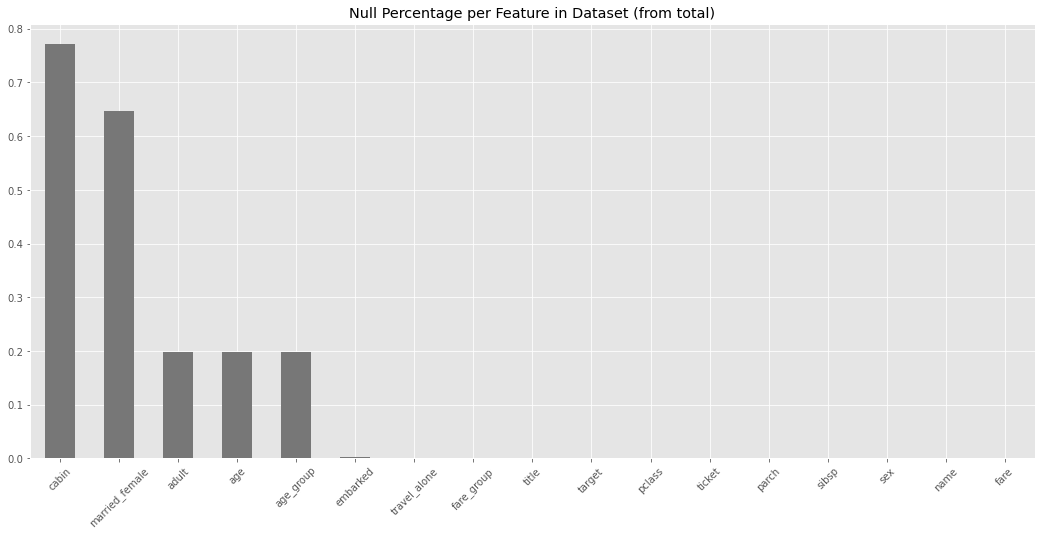

In [130]:
ax = (
    df_interim.isna().sum().sort_values(ascending=False) / len(df_interim)
    ).plot.bar(
        title="Null Percentage per Feature in Dataset (from total)",
        color=ggcolors[3]
        )
for label in ax.get_xticklabels(): label.set_rotation(45);

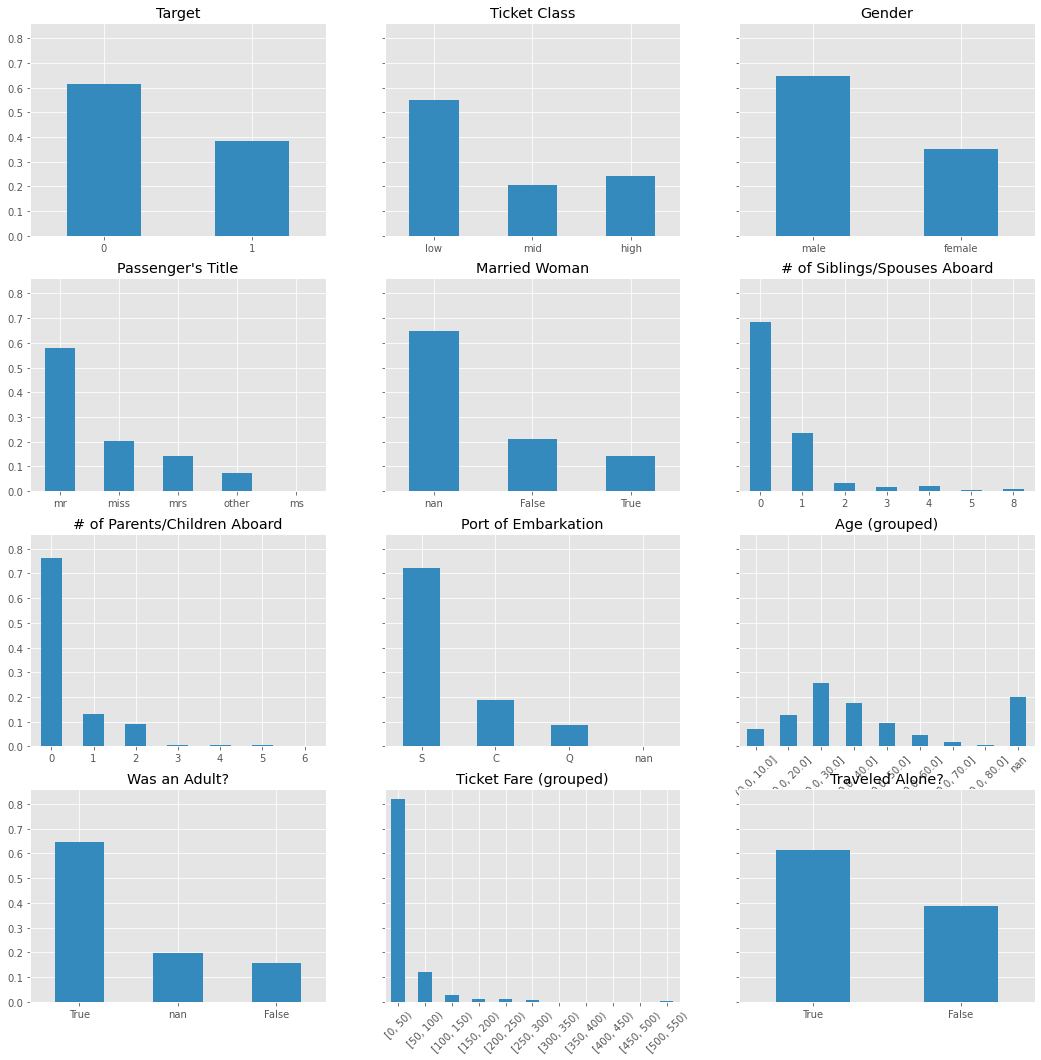

In [131]:
fig, axs = subplots(4, 3, figsize=(18, 18), sharey=True)

features = ["target", "pclass", "sex", "title", "married_female", 
            "sibsp", "parch", "embarked", 
            "age_group", "adult", "fare_group", "travel_alone"]
titles = ["Target", "Ticket Class", "Gender", "Passenger's Title", "Married Woman", 
          "# of Siblings/Spouses Aboard", "# of Parents/Children Aboard", "Port of Embarkation", 
          "Age (grouped)", "Was an Adult?", "Ticket Fare (grouped)", "Traveled Alone?"]
colors = [ggcolors[1]]*len(features)
sorts= [False, True, False, False, False, True, True, False, True, False, True, False]

counts = defaultdict(dict)
for i, plot_config in enumerate(zip(features, titles, colors, sorts)):
    counts[plot_config[0]] = plot_perc_from_total(
        kind="bar", 
        df=df_interim, 
        column=plot_config[0], 
        title=plot_config[1], 
        color=plot_config[2], 
        sort_index=plot_config[3], 
        ax=axs[i//3, i%3]
        )

In [132]:
numerical, categorical, dates, other = get_features(df_interim.drop("target", axis=1, inplace=False))

In [133]:
print("Numerical features:", ", ".join(numerical))
print("Categorical features:", ", ".join(categorical))
print("Dates features:", ", ".join(dates))
print("Undefined features:", ", ".join(other))

Numerical features: age, sibsp, parch, fare
Categorical features: pclass, name, sex, ticket, cabin, embarked, title, married_female, age_group, fare_group, adult
Dates features: 
Undefined features: travel_alone
